In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")


# standard
import json, pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from itertools import combinations
from scipy import stats
import math
from matplotlib.ticker import FormatStrFormatter

sys.path.append('/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/')
import PPILinkPred as pred
sys.path.append('/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook')

import genData_helper as helper
import traversalHelper as tr
import helper as hr

In [ ]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

In [ ]:
def standardize_plots_old(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate(limit_direction='both'))))
    return alignedPrecsList, baseRecs

def standardize_plots(prec, rec, decimalPt=5):
    std_rec = [float(i/10**decimalPt) for i in range(
        0, int(min([r[-1] for r in rec])*(10**decimalPt)))] # std rec
    corrStr = "{0:."+str(decimalPt)+"f}" # corr rec
    tmp = []
    for r in rec: tmp.append(np.asarray([float(corrStr.format(j)) for j in r]))
    rec = tmp.copy()
    fittedPrec = [] # map prec with n intervals
    for j in range(len(prec)):
        precsMap = {}
        for k in std_rec: precsMap[k] = np.nan
        for k in range(len(prec[j])):
            if rec[j][k] in precsMap: precsMap[rec[j][k]] = prec[j][k]
        mappedPrecs = pd.Series(list(precsMap.values()))
        fittedPrec.append(list(mappedPrecs.interpolate(limit_direction='both')))
    return fittedPrec, std_rec

def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

# init metadata

In [ ]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3N'\n($f_{1}$)", "L3N'\n($f_{2}$)", "L3N\n($f_{1}$)", "L3N\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3N'($f_{1}$)", "L3N'($f_{2}$)", "L3N($f_{1}$)", "L3N($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# read data into df

## contam 15,25

In [ ]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

#methods = ["L3E1_f1", "L3E_f1Alt", "L3E_f2Alt", "L3E1_f2"]
#ds_names = ['bioGRID', 'STRING', 'MINT']
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
ds_names = [ds+"_contam{}Percent".format(salt) for ds in ds_names for salt in [15,25]]

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,5):
            precRec = {}
            with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,biosnap_contam15Percent,0,0.000000,0.000000
1,50,1,CN,biosnap_contam15Percent,0,0.000000,0.000000
2,50,2,CN,biosnap_contam15Percent,0,0.000000,0.000000
3,50,3,CN,biosnap_contam15Percent,0,0.000000,0.000000
4,50,4,CN,biosnap_contam15Percent,0,0.000000,0.000000
...,...,...,...,...,...,...,...
133315,50,559,L3E1_f2,ddinter_R_contam25Percent,4,0.512500,0.084511
133316,50,560,L3E1_f2,ddinter_R_contam25Percent,4,0.511586,0.084511
133317,50,561,L3E1_f2,ddinter_R_contam25Percent,4,0.512456,0.084806
133318,50,562,L3E1_f2,ddinter_R_contam25Percent,4,0.513321,0.085100


## 0.5

In [ ]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

#methods = ["L3E1_f1", "L3E_f1Alt", "L3E_f2Alt", "L3E1_f2"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
#ds_names = ['bioGRID_5FoldCV', 'STRING_5FoldCV', 'MINT_5FoldCV'] # means have self PPIs lol

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(5):
            precRec = {}
            with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,biosnap,0,0.000000,0.000000
1,50,1,CN,biosnap,0,0.000000,0.000000
2,50,2,CN,biosnap,0,0.000000,0.000000
3,50,3,CN,biosnap,0,0.000000,0.000000
4,50,4,CN,biosnap,0,0.000000,0.000000
...,...,...,...,...,...,...,...
267275,50,2257,L3E1_f2,ddinter_R,4,0.446413,0.445230
267276,50,2258,L3E1_f2,ddinter_R,4,0.446658,0.445671
267277,50,2259,L3E1_f2,ddinter_R,4,0.446460,0.445671
267278,50,2260,L3E1_f2,ddinter_R,4,0.446263,0.445671


## 5fold

In [19]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

#methods = ["L3E1_f1", "L3E_f1Alt", "L3E_f2Alt", "L3E1_f2"]
#ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
ds_names = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV'] # means have self PPIs lol

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(5):
            precRec = {}
            with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,biosnap_5FoldCV,0,0.000000,0.000000
1,50,1,CN,biosnap_5FoldCV,0,0.000000,0.000000
2,50,2,CN,biosnap_5FoldCV,0,0.000000,0.000000
3,50,3,CN,biosnap_5FoldCV,0,0.000000,0.000000
4,50,4,CN,biosnap_5FoldCV,0,0.000000,0.000000
...,...,...,...,...,...,...,...
106795,50,899,L3E1_f2,ddinter_R_5FoldCV,4,0.434444,0.432044
106796,50,900,L3E1_f2,ddinter_R_5FoldCV,4,0.433962,0.432044
106797,50,901,L3E1_f2,ddinter_R_5FoldCV,4,0.433481,0.432044
106798,50,902,L3E1_f2,ddinter_R_5FoldCV,4,0.433001,0.432044


## 60-100,10

In [ ]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

for randSz in range(60, 100, 10):
    for ds in ds_names:
        for method in methods:
            for i in range(0,10):
                precRec = {}
                with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/{}_{}_randSz{}_topPPI_{}.json".format(method, ds, randSz, i), "r") as f:
                    precRec = json.loads(f.read())

                    df["randSz"] += [randSz for j in range(len(precRec['prec']))]
                    df["rank"] += [j for j in range(len(precRec['prec']))]
                    df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                    df['ds'] += [ds for j in range(len(precRec['prec']))]
                    df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                    df['prec'] += precRec['prec']
                    df['rec'] += precRec['rec']

df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,biosnap,0,0.000000,0.000000
1,50,1,CN,biosnap,0,0.000000,0.000000
2,50,2,CN,biosnap,0,0.000000,0.000000
3,50,3,CN,biosnap,0,0.000000,0.000000
4,50,4,CN,biosnap,0,0.000000,0.000000
...,...,...,...,...,...,...,...
1402305,90,446,L3E1_f2,ddinter_R,9,0.427293,0.421634
1402306,90,447,L3E1_f2,ddinter_R,9,0.426339,0.421634
1402307,90,448,L3E1_f2,ddinter_R,9,0.425390,0.421634
1402308,90,449,L3E1_f2,ddinter_R,9,0.424444,0.421634


In [21]:
# neglecting L3E(f1) and L3E(f2) and parsing separately when needed
df.to_pickle("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/full_df_05.pkl")

In [22]:
df = pd.read_pickle("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/full_df_05.pkl")

# AUC of precision-recall, ranked from low to high

In [ ]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 91, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))


sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 91, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'ddinter_A': {'rand': 3.6036406385360786e-05, 'CRA': 0.0008377515622988906, 'CN': 0.0020542451943681953, 'Sim': 0.15516746039574705, 'CH2': 0.2654961411422567, 'L3': 0.2689885361818113, 'L3E1_f2': 0.2844305755460292, 'L3E1_f1': 0.3269186001417341}, 'biosnap': {'rand': 0.00022271710978846406, 'CRA': 0.0018288363587663254, 'CN': 0.004893555371104937, 'L3': 0.01863050481329276, 'CH2': 0.0192204028681389, 'L3E1_f2': 0.020306051110341058, 'Sim': 0.02257445326144176, 'L3E1_f1': 0.023169623796999925}, 'ddinter_R': {'rand': 1.5770749869447298e-05, 'CRA': 0.0017166187945279593, 'CN': 0.0027155973330139577, 'Sim': 0.19822161174629663, 'L3': 0.26583482730428853, 'CH2': 0.2812405461851256, 'L3E1_f2': 0.2854320869902196, 'L3E1_f1': 0.3352760358993272}}, 60: {'ddinter_A': {'rand': 2.0953797376654062e-05, 'CRA': 0.0011456696707601755, 'CN': 0.0019683403445645794, 'Sim': 0.1450935843405516, 'L3': 0.242934336645938, 'CH2': 0.24814616141864568, 'L3E1_f2': 0.2746347039962691, 'L3E1_f1': 0.311319693

In [ ]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
#methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]

for randSz in range(50, 51, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))


sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'ddinter_A': {'rand': 3.6036406385360786e-05, 'CRA': 0.0008377515622988906, 'CN': 0.0020542451943681953, 'Sim': 0.15516746039574705, 'CH2': 0.2654961411422567, 'L3': 0.2689885361818113, 'L3E1_f2': 0.2844305755460292, 'L3E1_f1': 0.3269186001417341}, 'biosnap': {'rand': 0.00022271710978846406, 'CRA': 0.0018288363587663254, 'CN': 0.004893555371104937, 'L3': 0.01863050481329276, 'CH2': 0.0192204028681389, 'L3E1_f2': 0.020306051110341058, 'Sim': 0.02257445326144176, 'L3E1_f1': 0.023169623796999925}, 'ddinter_R': {'rand': 1.5770749869447298e-05, 'CRA': 0.0017166187945279593, 'CN': 0.0027155973330139577, 'Sim': 0.19822161174629663, 'L3': 0.26583482730428853, 'CH2': 0.2812405461851256, 'L3E1_f2': 0.2854320869902196, 'L3E1_f1': 0.3352760358993272}}}


In [ ]:
auc_map = {}

methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 51, 10):
    print(randSz)
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

50
{50: {'ddinter_A': {'rand': 4.554163100915887e-05, 'CRA': 0.0008028966288294038, 'CN': 0.002165545681199611, 'Sim': 0.15175297634623064, 'CH2': 0.26500998120292363, 'L3': 0.271688498576477, 'L3E1_f2': 0.2777545494883861, 'L3E1_f1': 0.3247312715416161}, 'biosnap': {'rand': 0.00022416787509231656, 'CRA': 0.0017927711395057829, 'CN': 0.0050124563461269814, 'L3': 0.019083375911915536, 'CH2': 0.02004054054371463, 'L3E1_f2': 0.020468319269337225, 'Sim': 0.022703916283527362, 'L3E1_f1': 0.023445857658799245}, 'ddinter_R': {'rand': 1.2766338063635228e-05, 'CRA': 0.001724537947492046, 'CN': 0.002769358050489883, 'Sim': 0.19418324326596662, 'L3': 0.2608156795346491, 'CH2': 0.2776131863687593, 'L3E1_f2': 0.2857215377537307, 'L3E1_f1': 0.3331443759782547}}}


## 5foldCV

In [23]:
auc_map = {}

methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 51, 10):
    print(randSz)
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

50
{50: {'ddinter_R_5FoldCV': {'rand': 1.1690172256246405e-06, 'CN': 0.0018407977785413116, 'CRA': 0.002279286032530392, 'Sim': 0.1590039396798773, 'L3': 0.16563020655999133, 'L3E1_f2': 0.23628412603892396, 'CH2': 0.24047593356303362, 'L3E1_f1': 0.27698538352777863}, 'ddinter_A_5FoldCV': {'rand': 2.5088171772884625e-06, 'CRA': 0.000470916489950715, 'CN': 0.0008399951116197558, 'Sim': 0.07860997583175314, 'L3': 0.15657588519116536, 'CH2': 0.1715591225350658, 'L3E1_f2': 0.18284763196210288, 'L3E1_f1': 0.21794357468044406}, 'biosnap_5FoldCV': {'rand': 2.1383656067272247e-05, 'CRA': 0.0018713929384467775, 'CN': 0.0018988057250976912, 'L3': 0.003966521458230769, 'CH2': 0.004233294612282862, 'L3E1_f2': 0.00549593818149463, 'Sim': 0.005503894700649344, 'L3E1_f1': 0.005574952734918854}}}


## 60 -100,10

In [ ]:
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_60-100.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_60-100.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_60-100.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_60-100.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_60-100.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_60-100.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [ ]:
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap_1', 'ddinter_A_1', 'ddinter_R_1']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for contam in [15,25]:
        aucVal = np.format_float_scientific(
            np.float32(sorted_mean_auc[50][ds+"_contam{}Percent".format(contam)]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

KeyError: 'biosnap_contam15Percent'

## comtam

In [ ]:
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_contam.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_contam.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_contam.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_contam.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_contam.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_contam.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [ ]:
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap_1', 'ddinter_A_1', 'ddinter_R_1']


for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 51, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} biosnap_1  & 2.227e-04 \\ \hline
\cellcolor{gray!15} ddinter_A_1  & 3.604e-05 \\ \hline
\cellcolor{gray!15} ddinter_R_1  & 1.577e-05 \\ \hline


## 5FoldCV

In [24]:
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_5foldcv.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_5foldcv.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_5foldcv.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_05.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_05.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_05.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [26]:
dss = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']
dsNames = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 51, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

KeyError: 'biosnap_5FoldCV'

## 0.5

In [ ]:
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_05.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_05.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_05.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_05.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/mean_auc_05.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/auc_err_05.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [ ]:
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap_1', 'ddinter_A_1', 'ddinter_R_1']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 51, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} biosnap_1  & 2.242e-04 \\ \hline
\cellcolor{gray!15} ddinter_A_1  & 4.554e-05 \\ \hline
\cellcolor{gray!15} ddinter_R_1  & 1.277e-05 \\ \hline


# p-value of PR AUC

## 5FoldCV

In [ ]:
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'CRA']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 L3E1_f2: 0.9148026909412998
L3E1_f1 CRA: 2.6395062428479203e-10
L3E1_f1 CRA: 2.533379084963452e-11


In [ ]:
for randSz in range(50, 51, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
biosnap_5FoldCV rand CN: 1.0865935339524657e-06
biosnap_5FoldCV rand CRA: 6.5674670714495465e-06
biosnap_5FoldCV rand L3: 9.327604989698418e-07
biosnap_5FoldCV rand CH2: 3.8677417286224683e-07
biosnap_5FoldCV rand Sim: 1.448827889456185e-06
biosnap_5FoldCV rand L3E1_f1: 3.236356072934135e-05
biosnap_5FoldCV rand L3E1_f2: 2.9160106349301818e-08
ddinter_A_5FoldCV rand CN: 4.5396439427332064e-05
ddinter_A_5FoldCV rand CRA: 9.762977601514926e-06
ddinter_A_5FoldCV rand L3: 6.895781725653113e-08
ddinter_A_5FoldCV rand CH2: 5.0642094796436225e-09
ddinter_A_5FoldCV rand Sim: 8.477208013689704e-08
ddinter_A_5FoldCV rand L3E1_f1: 2.593977403659498e-10
ddinter_A_5FoldCV rand L3E1_f2: 4.8963462310133545e-09
ddinter_R_5FoldCV rand CN: 7.900048372530467e-07
ddinter_R_5FoldCV rand CRA: 6.858768964435817e-07
ddinter_R_5FoldCV rand L3: 2.9766842569097985e-09
ddinter_R_5FoldCV rand CH2: 4.490746739721574e-11
ddinter_R_5FoldCV rand Sim: 7.652197902158837e-09
ddinter_R_5FoldCV rand L3E1_f1: 2.363223049

## 0.5

In [ ]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'CRA']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 L3E1_f2: 0.021997958864353618
L3E1_f1 CRA: 6.945533577145325e-11
L3E1_f1 CRA: 3.1179014403308925e-13


In [ ]:
# every p val to rand
# sample to do: top 2 both to third, between top 2
for randSz in range(50, 51, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
biosnap rand CN: 4.17567542482583e-08
biosnap rand CRA: 3.485628850083131e-05
biosnap rand L3: 6.727593093810713e-08
biosnap rand CH2: 5.192466841614844e-08
biosnap rand Sim: 1.838289094052984e-08
biosnap rand L3E1_f1: 1.8661731226584967e-09
biosnap rand L3E1_f2: 2.2011631015095356e-09
ddinter_A rand CN: 5.0875093470332885e-06
ddinter_A rand CRA: 0.007900899789323087
ddinter_A rand L3: 2.2476778661567142e-09
ddinter_A rand CH2: 1.9108717006069588e-08
ddinter_A rand Sim: 1.1798450543917038e-08
ddinter_A rand L3E1_f1: 6.793743066609065e-11
ddinter_A rand L3E1_f2: 9.470272750221812e-11
ddinter_R rand CN: 2.4897564371355323e-07
ddinter_R rand CRA: 0.0007540666802084502
ddinter_R rand L3: 1.2826473690809039e-11
ddinter_R rand CH2: 3.849027136313394e-11
ddinter_R rand Sim: 1.0709734520362326e-09
ddinter_R rand L3E1_f1: 2.904344229246882e-13
ddinter_R rand L3E1_f2: 4.9547100133923817e-11


## 60-100,10

In [ ]:
pairs = {
    60: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    70: [['L3E1_f1', 'CRA'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    80: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']],
    90: [['L3E1_f1', 'L3E1_f2'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']]
}
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
for randSz in range(60, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        pair = pairs[randSz][i]
        pop1 = auc_map[randSz][ds][pair[0]]
        pop2 = auc_map[randSz][ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

60
biosnap L3E1_f2 L3E1_f1: 0.1666096466317384
ddinter_A CRA L3E1_f1: 9.713071785444424e-24
ddinter_R L3E1_f1 L3: 9.896722321530768e-11
70
biosnap L3E1_f1 CRA: 4.531274020705818e-13
ddinter_A CRA L3E1_f1: 9.634678881959297e-24
ddinter_R L3E1_f1 L3: 4.888994206282905e-13
80
biosnap L3E1_f2 L3E1_f1: 0.25671189340982276
ddinter_A CRA L3E1_f1: 9.022473593204405e-22
ddinter_R CRA L3E1_f1: 7.863634791493682e-22
90
biosnap L3E1_f1 L3E1_f2: 0.6433860615568423
ddinter_A CRA L3E1_f1: 2.35018646696319e-17
ddinter_R CRA L3E1_f1: 3.7698163699973653e-19


In [ ]:
# every p val to rand
# sample to do: top 2 both to third, between top 2
for randSz in range(50, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
biosnap rand CN: 1.552491456876151e-13
biosnap rand CRA: 3.41111764081584e-07
biosnap rand L3: 1.0224375547075573e-16
biosnap rand CH2: 2.2308514030081895e-17
biosnap rand Sim: 6.553708165747423e-19
biosnap rand L3E1_f1: 4.77747356905073e-20
biosnap rand L3E1_f2: 2.6754625993680353e-18
ddinter_A rand CN: 3.7413581364580455e-13
ddinter_A rand CRA: 5.38820458111239e-05
ddinter_A rand L3: 8.689412348134046e-22
ddinter_A rand CH2: 9.393564242558025e-20
ddinter_A rand Sim: 4.034893051083282e-18
ddinter_A rand L3E1_f1: 1.5013004002928897e-24
ddinter_A rand L3E1_f2: 4.1621803627717036e-23
ddinter_R rand CN: 1.5550197081156486e-15
ddinter_R rand CRA: 2.7752196337880183e-05
ddinter_R rand L3: 1.8549050145585935e-25
ddinter_R rand CH2: 3.3312422310054555e-25
ddinter_R rand Sim: 6.137295201342399e-21
ddinter_R rand L3E1_f1: 1.0589474891140756e-26
ddinter_R rand L3E1_f2: 8.383208685535336e-24
60
biosnap rand CN: 5.322586199979712e-15
biosnap rand CRA: 3.08325032631866e-13
biosnap rand L3: 2.351

## contam

In [ ]:
# the decreasing AUC of rand
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap_1', 'ddinter_A_1', 'ddinter_R_1']
predictors = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]

for i in range(len(dss)):
    ds = dss[i]
    print("\multicolumn{8}{|l|}{\\textbf{"+dsNames[i]+"}} \\\\ \hline")
    for contam in [15,25]:
        buildStr = ""
        for predictor in predictors:
            pop1 = auc_map[50][ds+"_contam{}Percent".format(contam)]['rand']
            pop2 = auc_map[50][ds+"_contam{}Percent".format(contam)][predictor]
            aucVal = np.format_float_scientific(
                np.float32(stats.ttest_ind(pop1, pop2)[1]), precision=0)
            buildStr += " & "+"".join(str(aucVal).split("."))
        print("\\cellcolor{gray!15} "+str(contam)+"\% of PPI replaced "+buildStr+" \\\\ \\hline")

\multicolumn{8}{|l|}{\textbf{biosnap_1}} \\ \hline
\cellcolor{gray!15} 15\% of PPI replaced  & 3e-05 & 6e-04 & 2e-06 & 9e-06 & 3e-06 & 8e-05 & 7e-04 \\ \hline
\cellcolor{gray!15} 25\% of PPI replaced  & 3e-05 & 1e-02 & 6e-06 & 2e-05 & 2e-04 & 3e-05 & 3e-04 \\ \hline
\multicolumn{8}{|l|}{\textbf{ddinter_A_1}} \\ \hline
\cellcolor{gray!15} 15\% of PPI replaced  & 1e-05 & 2e-02 & 6e-09 & 7e-09 & 8e-14 & 5e-11 & 2e-12 \\ \hline
\cellcolor{gray!15} 25\% of PPI replaced  & 8e-04 & 3e-01 & 2e-09 & 4e-09 & 4e-08 & 7e-07 & 3e-05 \\ \hline
\multicolumn{8}{|l|}{\textbf{ddinter_R_1}} \\ \hline
\cellcolor{gray!15} 15\% of PPI replaced  & 3e-06 & 5e-02 & 1e-10 & 1e-10 & 6e-10 & 6e-09 & 5e-08 \\ \hline
\cellcolor{gray!15} 25\% of PPI replaced  & 8e-03 & 2e-01 & 2e-10 & 3e-12 & 8e-12 & 2e-08 & 2e-06 \\ \hline


# precision-recall figure

## 60-100,10

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']




for randSz in range(50, 91, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_60-100.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
precRec = {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_60-100.pkl", "rb") as f:
    precRec = pickle.load(f)

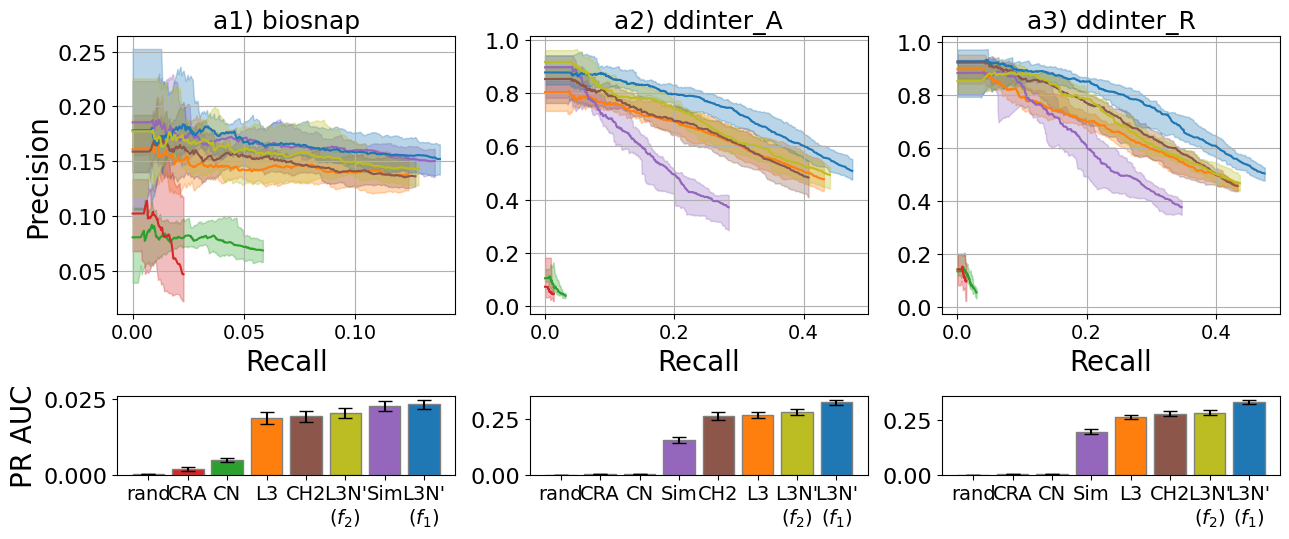

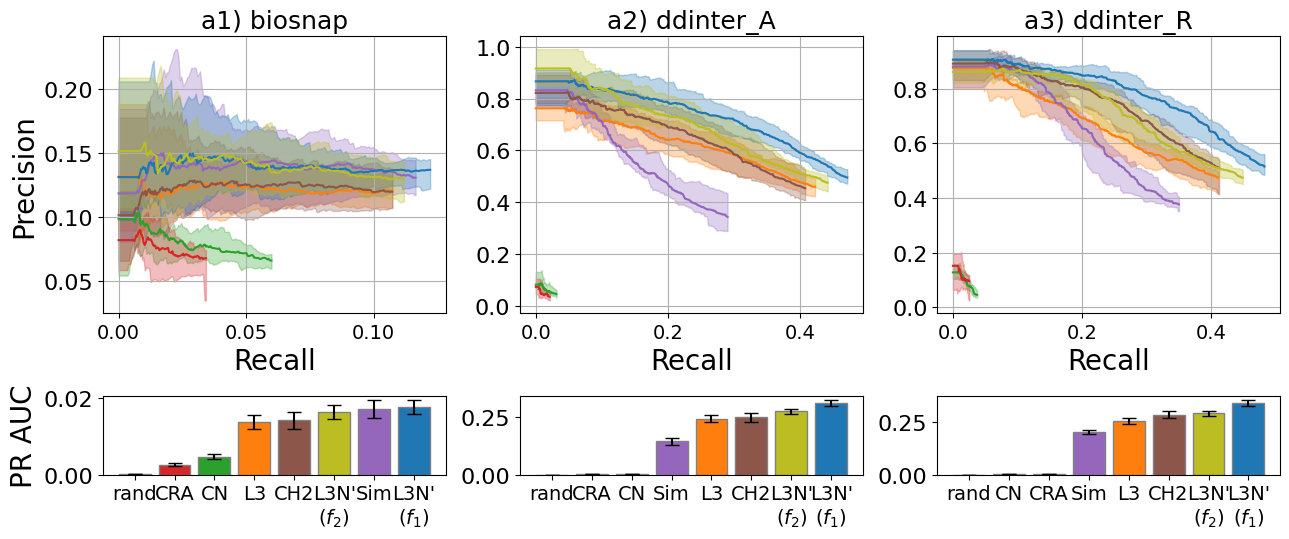

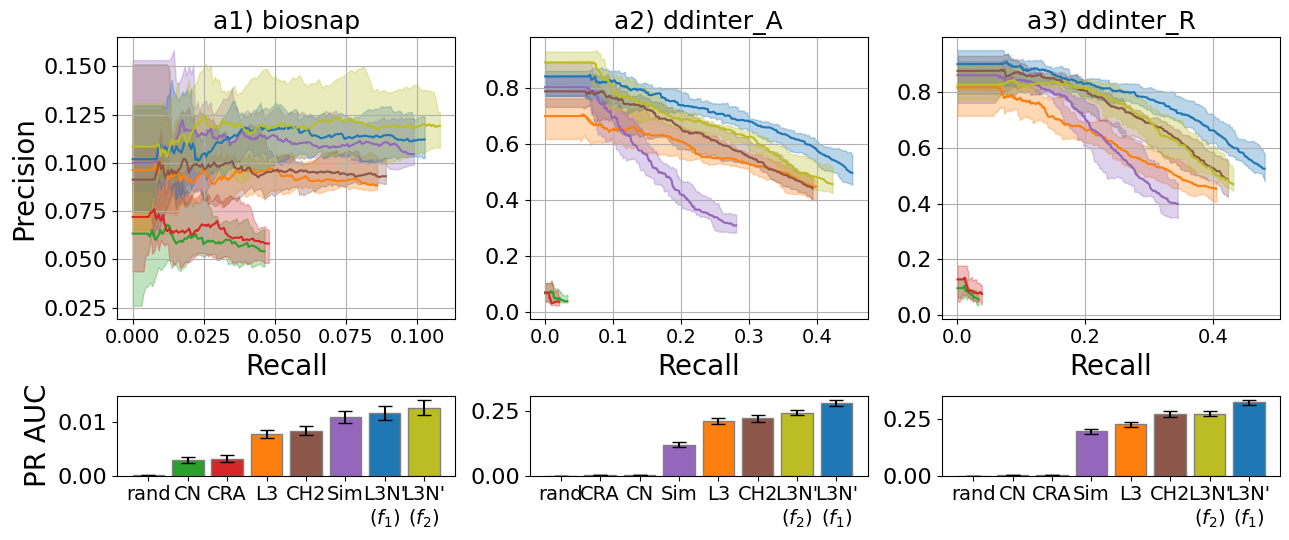

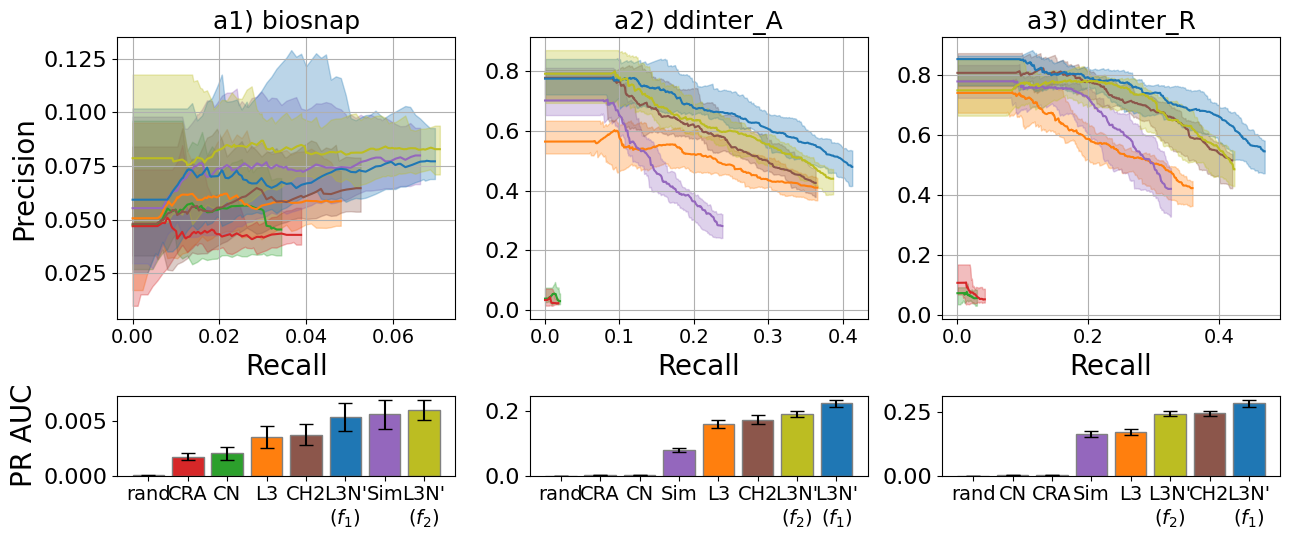

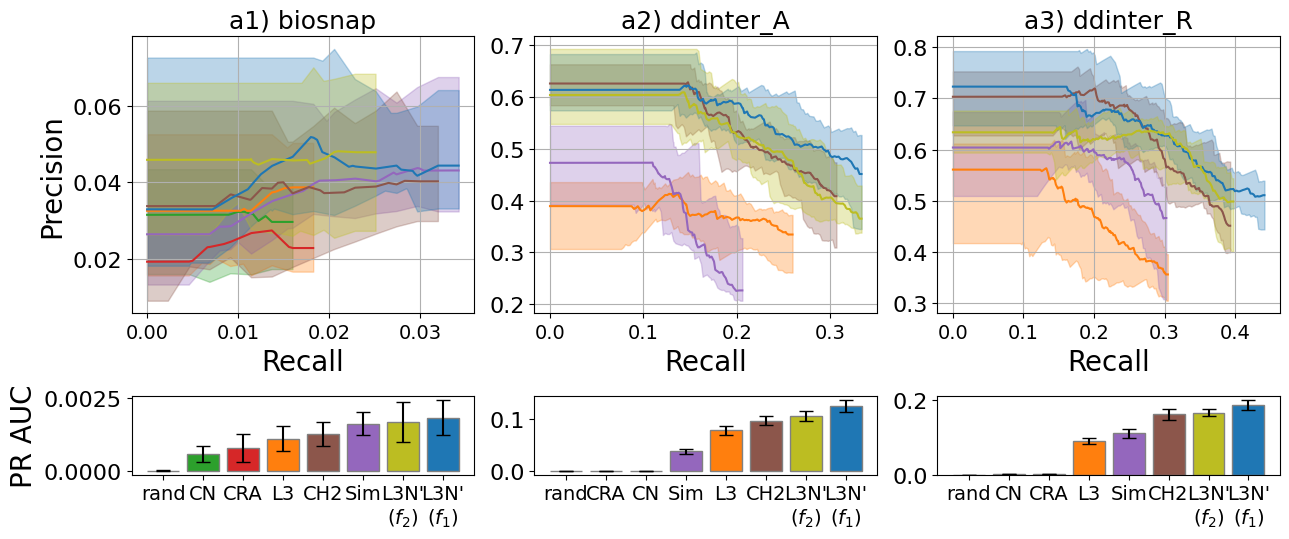

In [ ]:
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
    # lineAxes
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap', 'ddinter_A', 'ddinter_R']
for randSz in range(50, 100, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {}".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()

    plt.savefig("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/img_experiments/common_randSz{}.png".format(randSz), dpi=300)
    plt.show()

## 5FoldCV

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']




for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_5fold.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
precRec = {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_5fold.pkl", "rb") as f:
    precRec = pickle.load(f)

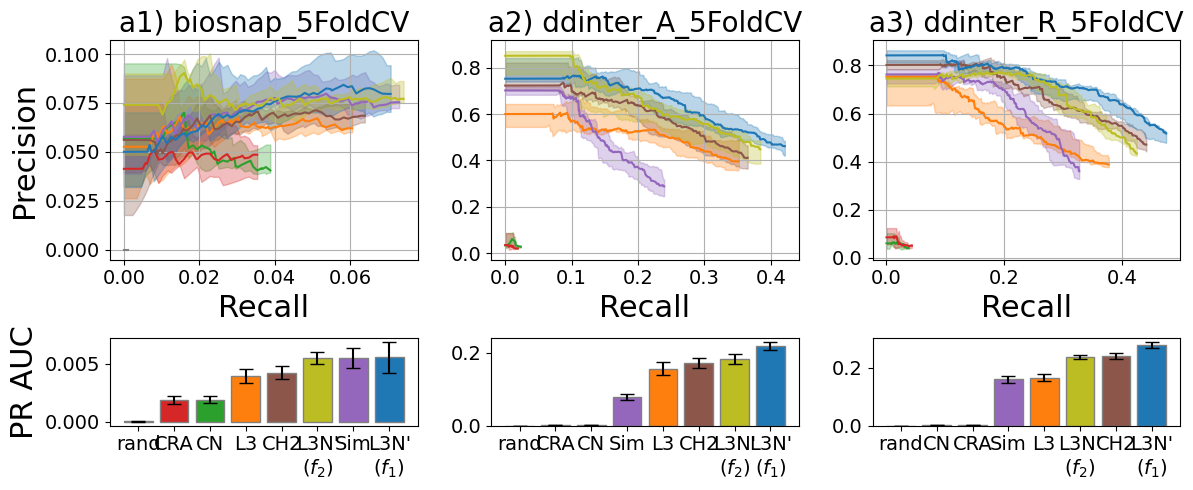

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=17)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']
dsNames = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['lowerPrec']
                , precRec[randSz][ds][method]['upperPrec']
                , facecolor=colors[method], color=colors[method]
                , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)

    ax.set_xlabel("Recall")
    ax.set_title("a{}) {}".format(i+1, dsNames[i]))
    ax.grid()
lineAxes[0].set_ylabel("Precision")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("PR AUC")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/img_experiments/common_5foldcv.png", dpi=300)
plt.show()

## Contam 15,25

In [ ]:
precRec = {}
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
ds_names = [ds+"_contam{}Percent".format(salt) for ds in ds_names for salt in [15,25]]
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
methods = [methods_names[i] for i in methods]

for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_contam.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
precRec = {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_contam.pkl", "rb") as f:
    precRec = pickle.load(f)

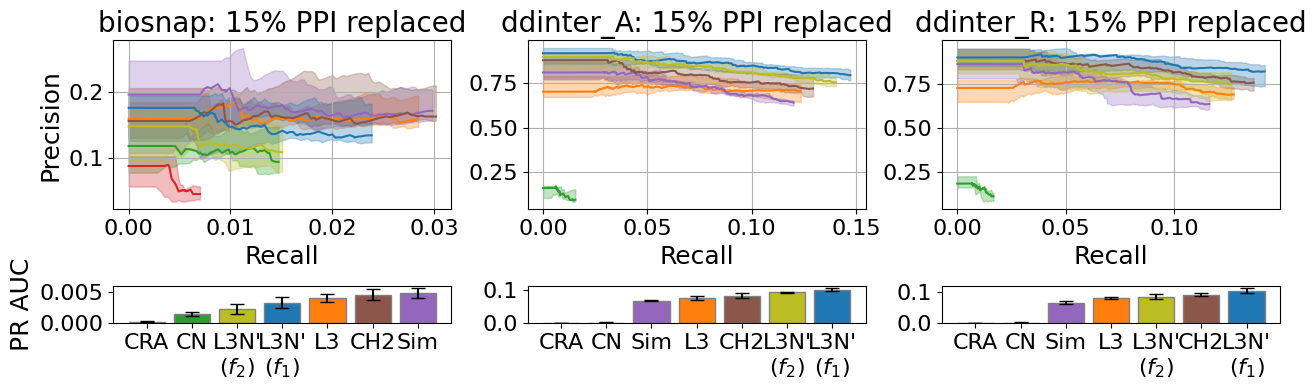

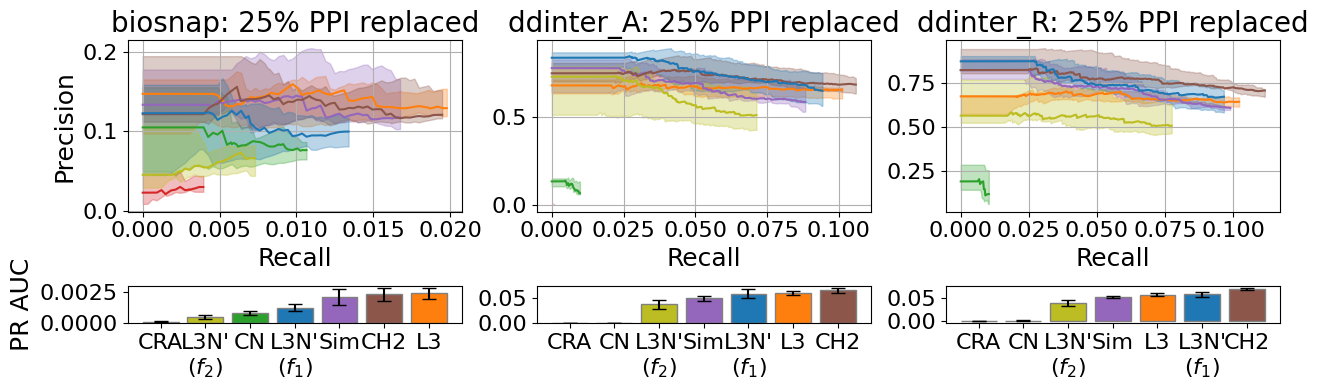

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
dss = [ds+"_contam{}Percent".format(contam) for contam in [15,25] for ds in ds_names]
dsNames = [ds+": {}% PPI replaced".format(contam) for contam in [15,25] for ds in ds_names]
for contamSz in range(int(len(dsNames)/len(ds_names))):
    fig = plt.figure(constrained_layout=True, figsize=(13, 4))
    widths = [1,1,1]
    heights = [6,1.3]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(contamSz*len(ds_names), contamSz*len(ds_names)+len(ds_names)):
        ds = dss[i]
        ax = lineAxes[i-contamSz*len(ds_names)]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title(dsNames[i])
        ax.grid()

        ax = barAxes[i-contamSz*len(ds_names)]
        xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)

    lineAxes[0].set_ylabel("Precision")
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/img_experiments/contam pr curves/L3E_yeast_PR_{}.png".format([5,10,15,20,25][contamSz]), dpi=300)
    plt.show()

## 0.5

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']




for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_05.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
precRec = {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves_05.pkl", "rb") as f:
    precRec = pickle.load(f)

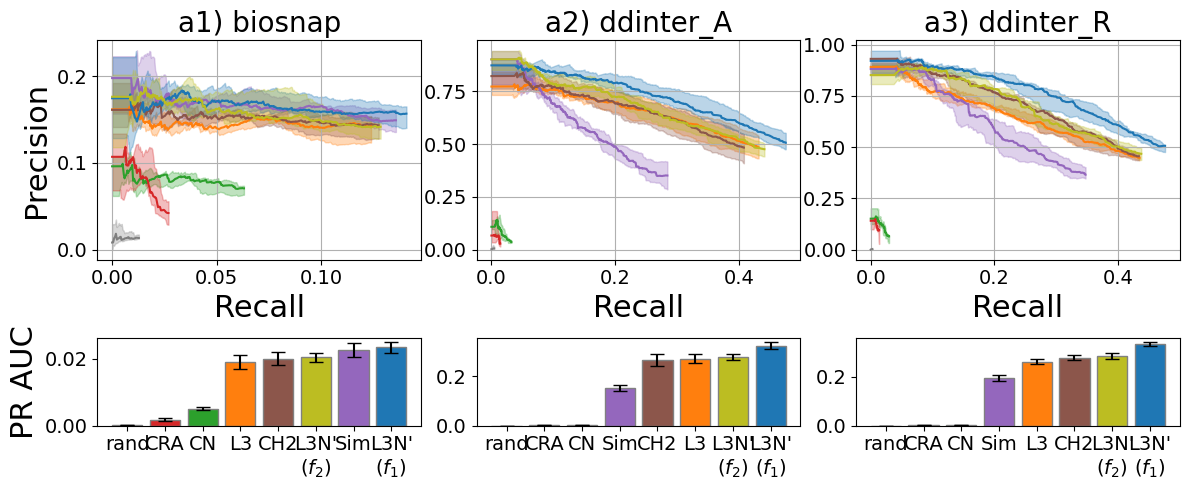

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=17)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap', 'ddinter_A', 'ddinter_R']
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['lowerPrec']
                , precRec[randSz][ds][method]['upperPrec']
                , facecolor=colors[method], color=colors[method]
                , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)

    ax.set_xlabel("Recall")
    ax.set_title("a{}) {}".format(i+1, dsNames[i]))
    ax.grid()
lineAxes[0].set_ylabel("Precision")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("PR AUC")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/img_experiments/common_05.png", dpi=300)
plt.show()

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']




for randSz in range(50, 100, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

ValueError: min() arg is an empty sequence

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['biosnap_5FoldCV', 'ddinter_A_5FoldCV', 'ddinter_R_5FoldCV']
'''methods = ["L3E1_f1", "L3E_f1Alt", "L3E1_f2", "L3E_f2Alt"]
ds_names = ['bioGRID', 'STRING', 'MINT']

['biosnap', 'ddinter_A', 'ddinter_R']'''
for randSz in range(50, 100, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec

ValueError: min() arg is an empty sequence

In [ ]:
precRec = {}
with open("/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/precision_recall_out/precRecCurves.pkl", "rb") as f:
    precRec = pickle.load(f)

KeyError: 'biosnap'

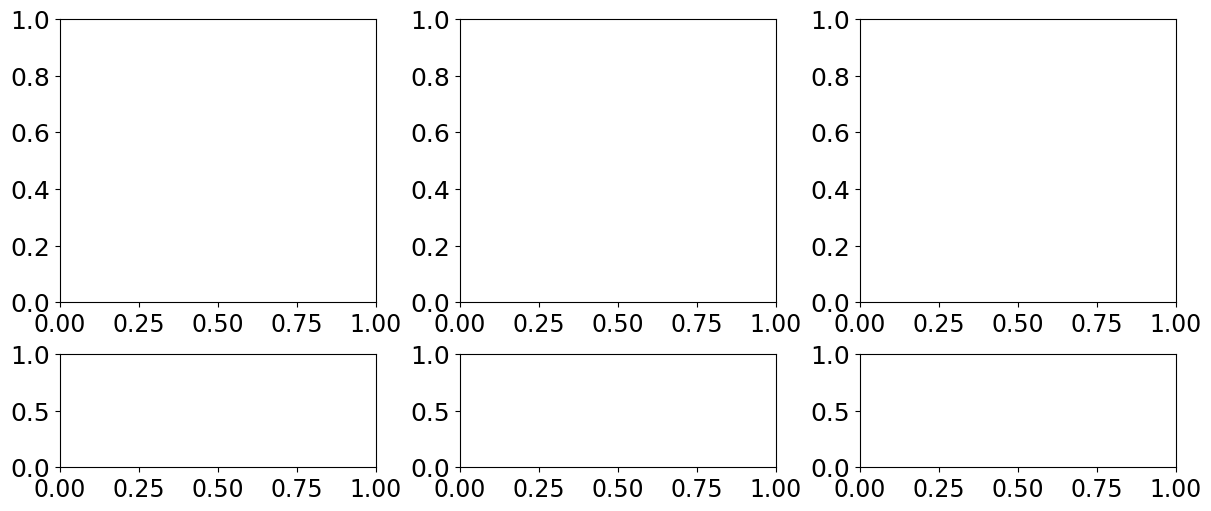

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['biosnap', 'ddinter_A', 'ddinter_R']
dsNames = ['biosnap', 'ddinter_A', 'ddinter_R']
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['lowerPrec']
                , precRec[randSz][ds][method]['upperPrec']
                , facecolor=colors[method], color=colors[method]
                , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)

    ax.set_xlabel("Recall")
    ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
    ax.grid()
lineAxes[0].set_ylabel("Precision")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("PR AUC")
plt.tight_layout()
plt.savefig("./img_experiments/L3EAlt_PR.png", dpi=300)
plt.show()

In [ ]:
dss = ['bioGRID', 'STRING', 'MINT']
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

pairs = [['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID L3E1_f1 L3E_f1Alt: 0.000736370685154239
STRING L3E1_f1 L3E_f1Alt: 2.697691484213646e-06
MINT L3E1_f1 L3E_f1Alt: 0.020575511647665894
bioGRID L3E1_f2 L3E_f2Alt: 0.00028708938092745286
STRING L3E1_f2 L3E_f2Alt: 0.05864367970950852
MINT L3E1_f2 L3E_f2Alt: 8.363239897272403e-05


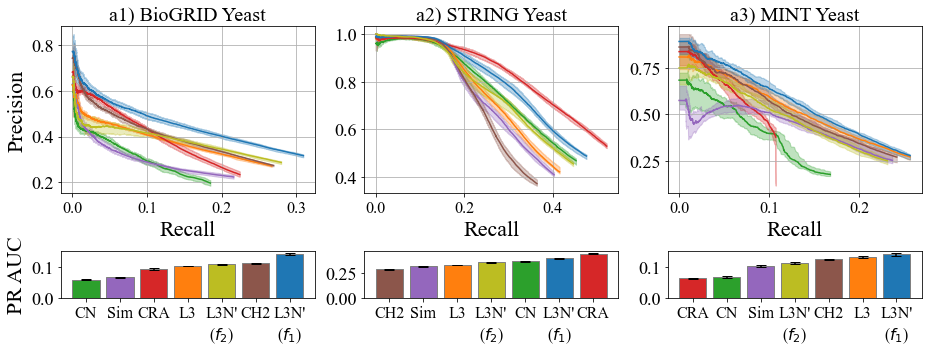

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for randSz in range(50, 51, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/L3E_yeast_PR.png", dpi=300)
    plt.show()

## 5-foldCV

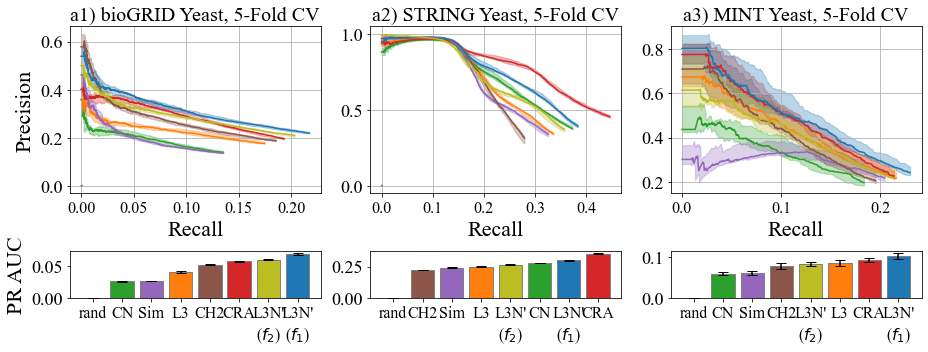

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID_5FoldCV', 'STRING_5FoldCV', 'MINT_5FoldCV']
dsNames = ['bioGRID', 'STRING', 'MINT']
for randSz in range(50, 51, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", 'rand']:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast, 5-Fold CV".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/KFold_yeast_PR.png", dpi=300)
    plt.show()

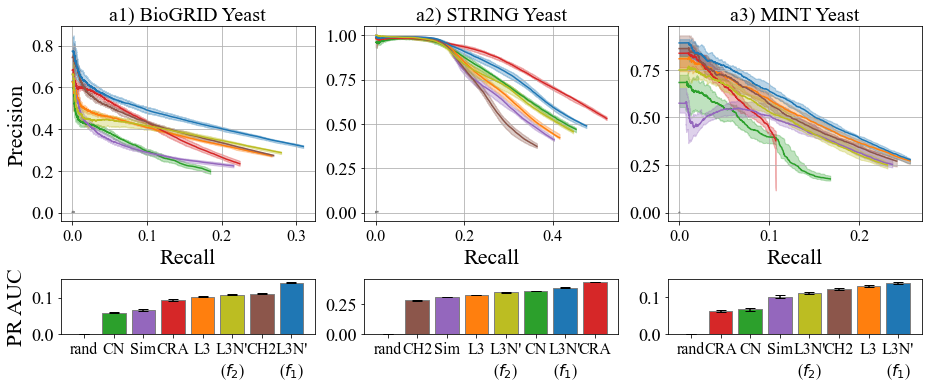

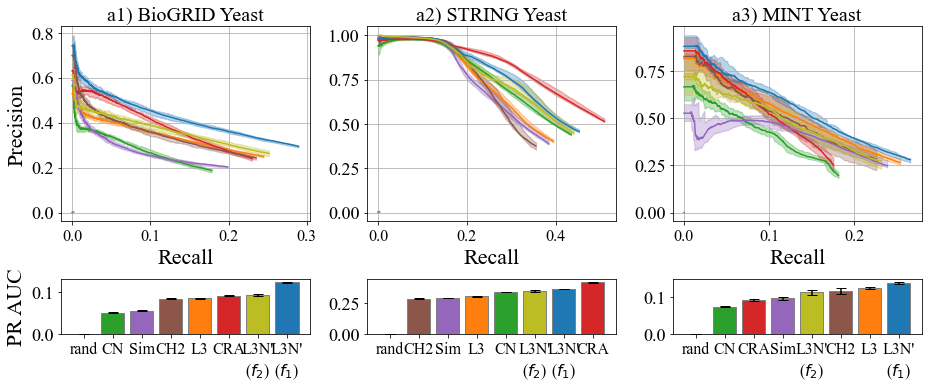

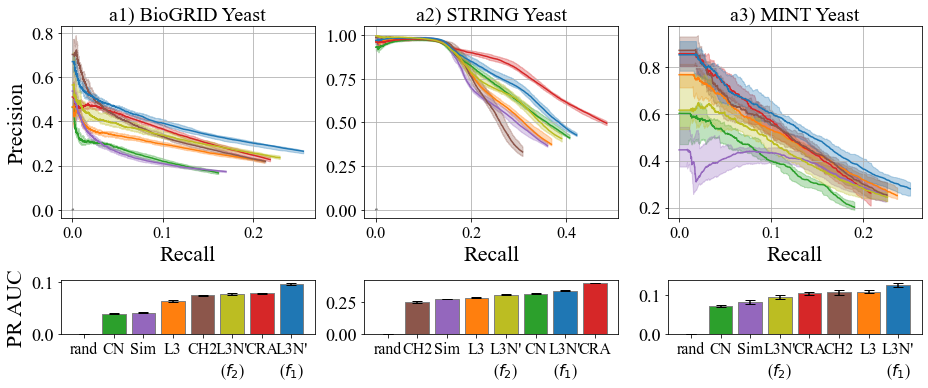

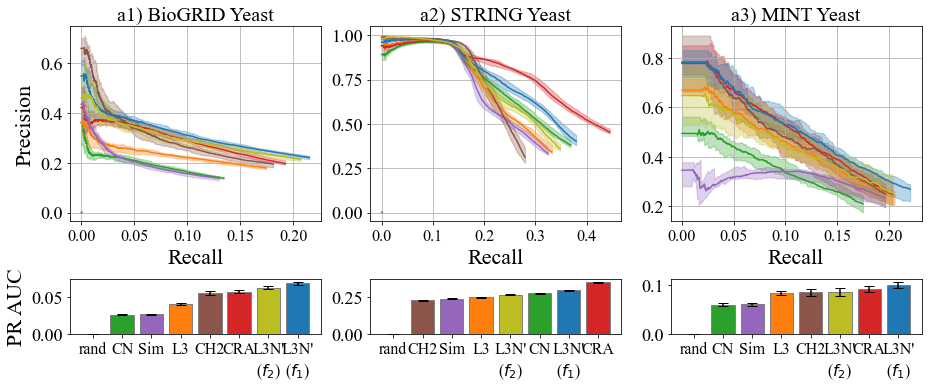

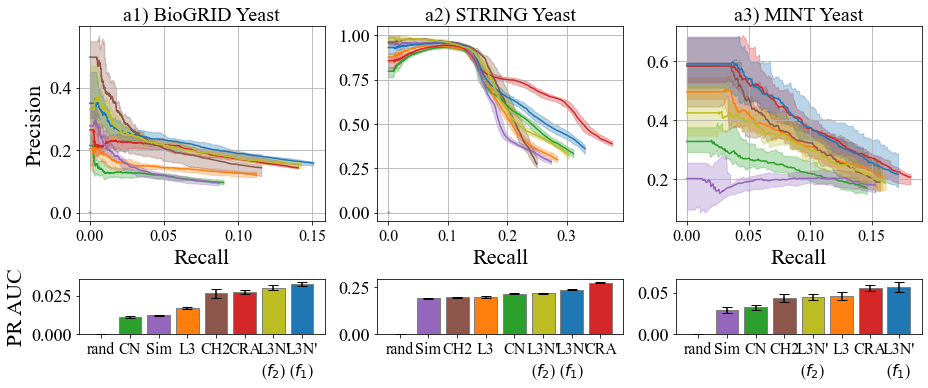

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for randSz in range(50, 100, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/L3E_yeast_PR_randSz{}.png".format(randSz), dpi=300)
    plt.show()

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

randSz = 50
# lineAxes
dss = ['bioGRID_noSelf']
dsNames = ['BioGRID Yeast, with SIPs']
fig = plt.figure(constrained_layout=True, figsize=(5, 5.5))
widths = [1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(1)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(1)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                        , precRec[randSz][ds][method]['lowerPrec']
                        , precRec[randSz][ds][method]['upperPrec']
                        , facecolor=colors[method], color=colors[method]
                        , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)
    ax.set_xlabel("Recall")
    ax.grid()
    ax.set_title(dsNames[i])

    # barAxes
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)

lineAxes[0].set_ylabel("Precision")
barAxes[0].set_ylabel("AUC")

plt.tight_layout()
plt.savefig("./img_experiments/bioGRID_SIPs_PRAUC.png", dpi=300)
plt.show()

# PR AUC w.r.t randSz

In [ ]:
auc_perRandsz = auc_map.copy()

auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in set(df['ds']):
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'] == ds) & (df['method'] == method)]
        for  trial in range(10):
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(50, 100, 10)],
                                                   [auc_perRandsz[j][ds][method][trial] for j in range(50, 100, 10)]))


sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'MINT': {'CN': 0.025787748015073886, 'Sim': 0.03067565055332012, 'CRA': 0.03489939110903559, 'L3E1_f2': 0.03748873521921791, 'CH2': 0.03929937761131472, 'L3': 0.04074845272994319, 'L3E1_f1': 0.04638184717381413}, 'bioGRID': {'CN': 0.015245259779568041, 'Sim': 0.016364867486228993, 'L3': 0.024912698060739976, 'CH2': 0.02828212331324973, 'CRA': 0.02872887276375608, 'L3E1_f2': 0.03016583275421921, 'L3E1_f1': 0.037426089791133904}, 'STRING': {'CH2': 0.10041632994857648, 'Sim': 0.10575170481610412, 'L3': 0.11013922009951087, 'L3E1_f2': 0.12077799334045872, 'CN': 0.12177640935748073, 'L3E1_f1': 0.13115474947215178, 'CRA': 0.15203226921448637}}


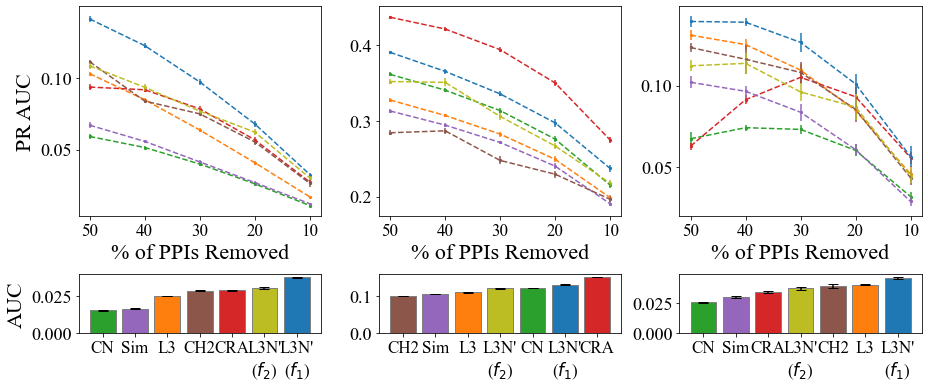

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 0, -10)]
                    , [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 0, -10)],
                   [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                   s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Removed")
        ax.set_xticks([randSz for randSz in range(50, 0, -10)])
    ax.set_xlim(ax.get_xlim()[::-1])
lineAxes[0].set_ylabel("PR AUC")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("AUC")
plt.tight_layout()
plt.savefig("./img_experiments/L3E_yeast_PRAUC.png", dpi=300)
plt.show()

In [ ]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'L3']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[ds][pairs[i][0]]
    pop2 = auc_map[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID L3E1_f1 L3E1_f2: 1.0794953129363955e-18
STRING L3E1_f1 CRA: 6.4703309888849304e-24
MINT L3E1_f1 L3: 8.114572987556221e-11


# PR AUC w.r.t contamSz

In [ ]:
auc_perContamsz = auc_map.copy()

auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in ['bioGRID', 'STRING', 'MINT']:
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'].str.contains(ds)) & (df['method'] == method)]
        for trial in range(10):
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(5, 26, 5)],
                                       [auc_perContamsz[50]["{}_contam{}Percent".format(
                                           ds, contam)][method][trial] for contam in range(5, 26, 5)])
                                      )


sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'bioGRID': {'CN': 0.011279772584239716, 'CRA': 0.011473891304492839, 'Sim': 0.01683209655304676, 'L3': 0.021446535197045122, 'CH2': 0.02266136949200809, 'L3E1_f2': 0.022903954872716757, 'L3E1_f1': 0.027020319104560854}, 'STRING': {'CH2': 0.05545488797034877, 'Sim': 0.060423073965826635, 'L3': 0.06255168570034378, 'L3E1_f2': 0.06500097860470935, 'CN': 0.06837808766686496, 'L3E1_f1': 0.06988511993199756, 'CRA': 0.07603194734570426}, 'MINT': {'CRA': 0.003944880403772274, 'CN': 0.007207103007243884, 'L3E1_f2': 0.009835129079070349, 'L3E1_f1': 0.01399206194377233, 'Sim': 0.014542030726493876, 'CH2': 0.017003746362299607, 'L3': 0.017760393549347588}}


In [ ]:
# mean slope
auc_perContamsz = auc_map.copy()
auc_changes = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in ['bioGRID', 'STRING', 'MINT']:
    auc_changes[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'].str.contains(ds)) & (df['method'] == method)]
        aucs = [np.mean(auc_perContamsz[50]["{}_contam{}Percent".format(ds, contam)][method]) for contam in range(5, 26, 5)]
        auc_changes[ds][method] = [(aucs[j]-aucs[j-1])/aucs[j-1] for j in range(1, len(aucs))]

sorted_meanChg_auc, err_aucChg = {}, {}
for ds in auc_changes:
    sorted_meanChg_auc[ds], err_aucChg[ds] = {}, {}
    for method in auc_changes[ds]:
        sorted_meanChg_auc[ds][method] = np.mean(auc_changes[ds][method])
        err_aucChg[ds][method] = np.std(auc_changes[ds][method])
    sorted_meanChg_auc[ds] = dict(sorted(sorted_meanChg_auc[ds].items(), key=lambda item: item[1])[::-1])

print(sorted_meanChg_auc)

{'bioGRID': {'Sim': 0.04710472903048109, 'L3': 0.00482632498940317, 'CH2': -0.004835922827252408, 'L3E1_f2': -0.019508703817647823, 'L3E1_f1': -0.03415062999774953, 'CN': -0.06047003483235025, 'CRA': -0.26768279068631606}, 'STRING': {'CH2': -0.007649117804860763, 'Sim': -0.015465211976151402, 'L3': -0.019826999787895885, 'L3E1_f2': -0.027213341578991156, 'CN': -0.03257821805636343, 'L3E1_f1': -0.03726589010799502, 'CRA': -0.07163010116007565}, 'MINT': {'CH2': -0.21455066078813234, 'Sim': -0.21897658201811432, 'L3': -0.22614205825492517, 'CN': -0.3054829799089664, 'L3E1_f1': -0.39008270057151495, 'L3E1_f2': -0.45436335511796827, 'CRA': -0.5554592370843044}}


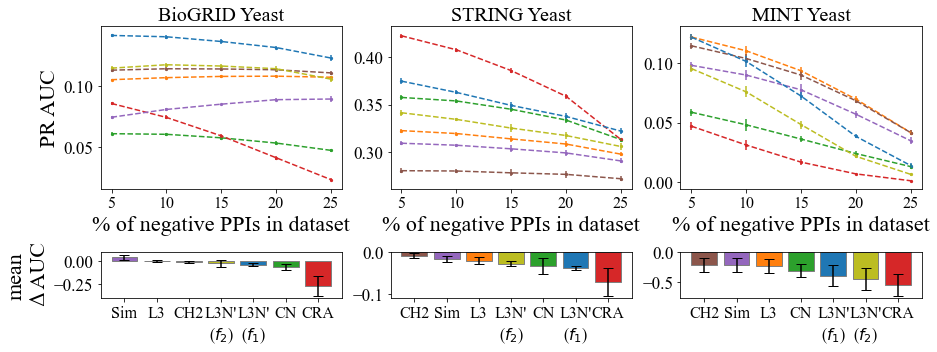

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=17)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
titles = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']
fig = plt.figure(constrained_layout=True, figsize=(13, 5))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
#barAxes2 = [fig.add_subplot(spec[2, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([contamSz for contamSz in range(5, 26, 5)]
                    , [np.mean(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)]
                    )))
        ax.scatter([contamSz for contamSz in range(5, 26, 5)],
                   [np.mean(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)],
                   s=5, color=colors[method])
        ax.set_xlabel("% of negative PPIs in dataset")
        ax.set_xticks([contamSz for contamSz in range(5, 26, 5)])
    #ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(titles[i])
lineAxes[0].set_ylabel("PR AUC")


'''
# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("AUC")
'''


for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_meanChg_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_meanChg_auc[ds][x] for x in xtick]
                      , yerr=[err_aucChg[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("mean\n Δ AUC")

plt.tight_layout()
plt.savefig("./img_experiments/L3E_contam_yeast_PRAUC.png", dpi=300)
plt.show()

In [ ]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['CH2', 'L3'], ['L3E1_f1', 'CH2'], ['CRA', 'L3E1_f2']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_changes[ds][pairs[i][0]]
    pop2 = auc_changes[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID CH2 L3: 0.29848349611936953
STRING L3E1_f1 CH2: 0.0006456560898020438
MINT CRA L3E1_f2: 0.529796041108317
